# Inferenza causale con trattamenti endogeni {#sec-endogenous-treatments}

**Prerequisiti**

- Consultare il capitolo 9 di [Causal Inference: A Statistical Learning Approach](https://web.stanford.edu/~swager/causal_inf_book.pdf) di Stefan Wager.

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import pingouin as pg
import statsmodels.api as sm
import networkx as nx
from graphviz import Digraph
from IPython.display import Image

In [3]:
seed: int = sum(map(ord, "subj_prop"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione {.unnumbered}

Quando parliamo di stima degli effetti dei trattamenti assumendo l'assenza di confondimento (unconfoundedness), di solito presupponiamo che, una volta considerati i fattori rilevanti, l'assegnazione del trattamento sia essenzialmente casuale. In altre parole, il trattamento è considerato "esogeno", ossia indipendente dalle variabili che vogliamo studiare. Questo approccio è utile in molte applicazioni, ma ci sono situazioni in cui tali assunzioni non sono realistiche. Ad esempio, quando si cerca di analizzare l'effetto della terapia cognitivo-comportamentale sulla riduzione dei sintomi depressivi, potrebbe non essere realistico supporre che l'assegnazione della terapia sia completamente casuale. Spesso, l'assegnazione può dipendere dalle caratteristiche del paziente o dal giudizio del terapeuta, creando così una relazione endogena tra trattamento e risultato.

In questo capitolo, affronteremo i metodi per l'inferenza causale in contesti dove l'assegnazione del trattamento è endogena, cioè dipendente dall'interazione con altre variabili del sistema. Introduciamo prima i modelli di equazioni strutturali (SEM) non-parametrici, che permettono di modellare tali relazioni. Successivamente, discuteremo i metodi delle variabili strumentali, utili quando l'assunzione di esogeneità non regge.

### Modelli di equazioni strutturali e il calcolo do

I modelli di equazioni strutturali (SEM) descrivono le relazioni causali tra variabili usando grafi aciclici diretti (DAG). Un DAG è un insieme di nodi collegati da frecce (o archi) che rappresentano le relazioni di causa-effetto tra variabili. Ad esempio, in un contesto psicologico, un nodo potrebbe rappresentare il livello di ansia di un individuo (Z1), mentre un altro nodo potrebbe rappresentare la probabilità di successo in una terapia cognitivo-comportamentale (Z2). Le frecce tra i nodi indicano la direzione del rapporto causale. Un DAG è aciclico, il che significa che non si creano cicli, cioè una variabile non può influenzare se stessa tramite una serie di effetti intermedi.

Per esempio, consideriamo un modello in cui l'ansia (Z1) influenza direttamente il successo della terapia (Z2) e, a sua volta, il successo della terapia influenza il benessere generale del paziente (Z3). Possiamo rappresentare questo sistema con un DAG dove ogni freccia mostra una relazione causale diretta tra queste variabili.

Quando parliamo di inferenza causale, possiamo usare il cosiddetto *calcolo do* introdotto da Judea Pearl. Questo metodo permette di rispondere a domande causali simulando l'intervento su una variabile e osservando come ciò influenzi le altre. Ad esempio, se vogliamo sapere come il cambiamento del trattamento psicologico influisca sul livello di ansia, possiamo usare l'operatore *do* per fissare il valore del trattamento e osservare come questo cambiamento si ripercuote sugli altri nodi nel DAG.

### Il criterio della "back-door"

Il calcolo do consente anche di identificare condizioni in cui possiamo rispondere a domande causali pur non osservando tutte le variabili rilevanti. Una di queste condizioni è il cosiddetto "criterio della back-door". Supponiamo di voler studiare l'effetto di una terapia cognitivo-comportamentale (W) sulla riduzione dei sintomi depressivi (Y), ma sospettiamo che ci siano variabili non osservate che influenzano sia l'assegnazione del trattamento che il risultato. Se riusciamo a trovare un insieme di variabili che blocca tutte le "vie" attraverso cui la confusione potrebbe verificarsi, possiamo ancora stimare l'effetto causale della terapia.

## Le variabili strumentali

In molti contesti psicologici, potremmo non essere in grado di osservare direttamente tutte le variabili confondenti. Per esempio, quando studiamo l'effetto della motivazione sul successo in una terapia, la motivazione potrebbe essere influenzata da fattori non osservati, come le esperienze di vita del paziente. In questi casi, le variabili strumentali possono aiutare. Un *strumento* è una variabile che è correlata al trattamento (ad esempio, la frequenza delle sedute terapeutiche), ma che non ha un effetto diretto sul risultato (la riduzione dei sintomi), se non attraverso il trattamento.

L'uso di variabili strumentali può essere illustrato con un esempio. Immagina di voler stimare l'effetto del supporto sociale (W) sulla riduzione dell'ansia (Y), ma sospetti che esistano fattori non osservati (U), come la personalità del paziente, che influenzano sia la scelta del supporto sociale che il livello di ansia. Se possiamo trovare una variabile strumentale, come la disponibilità di gruppi di supporto nella comunità (Z), che influenza l'uso del supporto sociale, ma che non è direttamente correlata all'ansia, possiamo usare Z per stimare l'effetto di W su Y.

## Simulazione

Per chiarire, facciamo un esempio numerico. Per simulare l'effetto del supporto sociale (W) sulla riduzione dell'ansia (Y) utilizzando variabili strumentali in un contesto di inferenza causale, possiamo ipotizzare una struttura con un confondente non osservato (U) e una variabile strumentale (Z). 

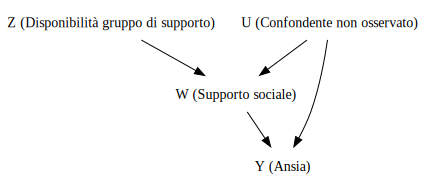

In [13]:
# Crea un grafo diretto (DAG) usando Graphviz 
dag_supporto_sociale = Digraph(comment="DAG Supporto Sociale")

# Definisci i nodi
dag_supporto_sociale.node(
    "Z", "Z (Disponibilità gruppo di supporto)", shape="plaintext"
)
dag_supporto_sociale.node("W", "W (Supporto sociale)", shape="plaintext")
dag_supporto_sociale.node("Y", "Y (Ansia)", shape="plaintext")
dag_supporto_sociale.node("U", "U (Confondente non osservato)", shape="plaintext")

# Aggiungi gli archi (relazioni causali)
dag_supporto_sociale.edge("Z", "W")
dag_supporto_sociale.edge("W", "Y")
dag_supporto_sociale.edge("U", "W")
dag_supporto_sociale.edge("U", "Y")

dag_supporto_sociale

### Step 1: Definizione del modello

Consideriamo il seguente modello lineare:

- $Y = \alpha + \tau W + \epsilon_Y$ dove $Y$ è il livello di ansia, $W$ è il supporto sociale, e $\epsilon_Y$ è un errore.
- $W = \beta Z + \eta$ dove $Z$ è la variabile strumentale (ad esempio, la disponibilità di gruppi di supporto sociale), e $\eta$ è un errore che incorpora il confondente non osservato $U$.
- $Z$ deve essere correlato a $W$ ma non direttamente a $Y$, a parte attraverso $W$.

### Step 2: Simulazione dei dati

Prima di procedere con la simulazione in Python, ipotizziamo dei valori ragionevoli per i parametri e generiamo i dati:

- $\alpha = 5$ (intercetta per il livello di ansia)
- $\tau = -1.5$ (effetto del supporto sociale sulla riduzione dell'ansia, che ci aspettiamo negativo)
- $\beta = 0.8$ (effetto della variabile strumentale sul supporto sociale)
- Gli errori $\epsilon_Y$ e $\eta$ sono normalmente distribuiti.

### Step 3: Implementazione in Python

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     264.7
Date:                Sat, 21 Sep 2024   Prob (F-statistic):           4.82e-48
Time:                        09:06:53   Log-Likelihood:                -696.41
No. Observations:                 500   AIC:                             1397.
Df Residuals:                     498   BIC:                             1405.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0323      0.044      0.741      0.4

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_45414/4164621354.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


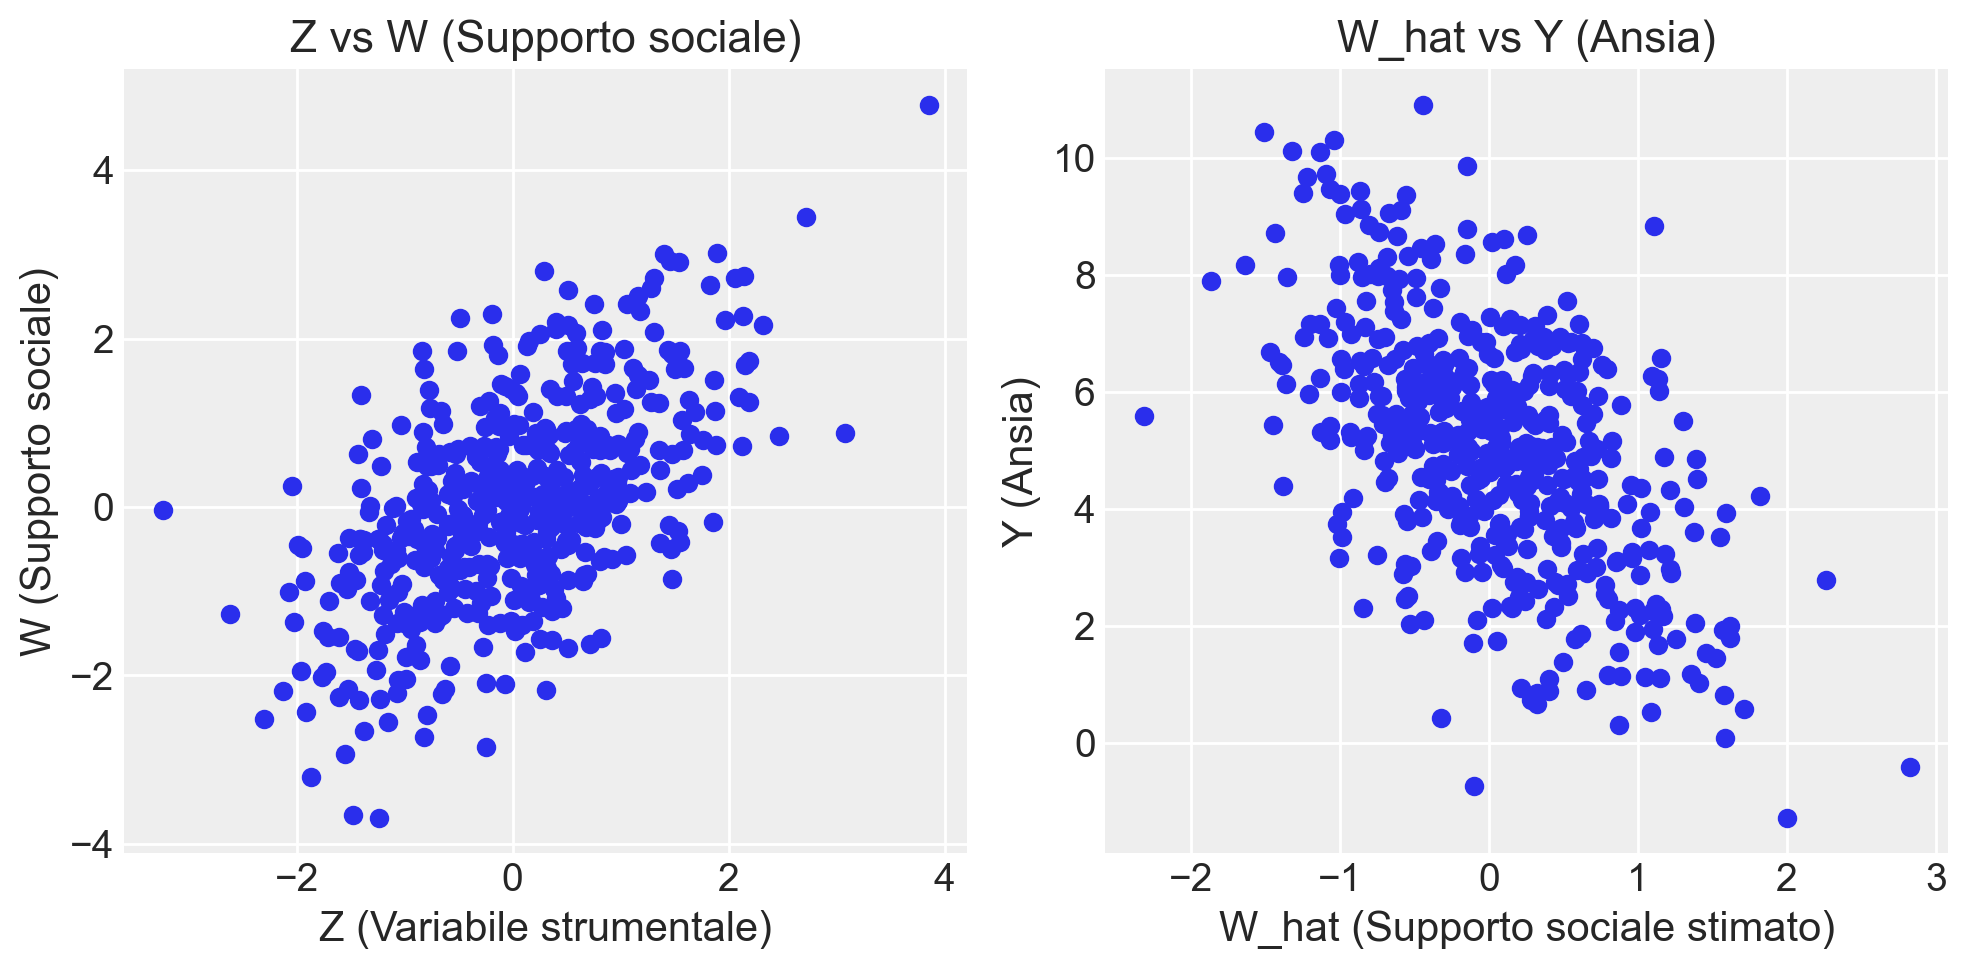

In [6]:
# Parametri
np.random.seed(42)
n = 500  # Numero di soggetti
alpha = 5
tau = -1.5
beta = 0.8
sigma_Y = 1  # Deviazione standard dell'errore su Y
sigma_W = 1  # Deviazione standard dell'errore su W

# Simulazione delle variabili
Z = np.random.normal(0, 1, n)  # Variabile strumentale
eta = np.random.normal(0, sigma_W, n)  # Errore per W
epsilon_Y = np.random.normal(0, sigma_Y, n)  # Errore per Y

# Modello del supporto sociale (W dipende da Z)
W = beta * Z + eta

# Modello dell'ansia (Y dipende da W)
Y = alpha + tau * W + epsilon_Y

# Creiamo un dataframe
data = pd.DataFrame({"Z": Z, "W": W, "Y": Y})

# Prima analisi: Regressione di W su Z 
X = sm.add_constant(data["Z"])  # Aggiungiamo la costante
model_W_Z = sm.OLS(data["W"], X).fit()  # Regressione W ~ Z
print(model_W_Z.summary())

# Prevediamo W (Fase 1 - previsioni di W in funzione di Z)
data["W_hat"] = model_W_Z.predict(X)

# Seconda fase: Regressione di Y su W_hat (usando Pingouin)
reg_y_w_hat = pg.linear_regression(data["W_hat"], data["Y"])
print(reg_y_w_hat)

# Visualizziamo la relazione tra le variabili
plt.figure(figsize=(10, 5))

# Scatter plot di Z vs W
plt.subplot(1, 2, 1)
plt.scatter(data["Z"], data["W"])
plt.title("Z vs W (Supporto sociale)")
plt.xlabel("Z (Variabile strumentale)")
plt.ylabel("W (Supporto sociale)")

# Scatter plot di W_hat vs Y
plt.subplot(1, 2, 2)
plt.scatter(data["W_hat"], data["Y"])
plt.title("W_hat vs Y (Ansia)")
plt.xlabel("W_hat (Supporto sociale stimato)")
plt.ylabel("Y (Ansia)")

plt.tight_layout()
plt.show()

### Spiegazione del codice:
1. **Simulazione**:
   - Generiamo una variabile strumentale $Z$, l'errore $\eta$ che influenza $W$, e $\epsilon_Y$, l'errore per $Y$.
   - Il supporto sociale $W$ dipende da $Z$ e dall'errore $\eta$.
   - Il livello di ansia $Y$ dipende da $W$ e dall'errore $\epsilon_Y$.

2. **Regressione con variabili strumentali**:
   - Prima stimiamo $W$ in funzione di $Z$ usando una regressione lineare.
   - Poi usiamo il valore stimato $W_{\text{hat}}$ per stimare l'effetto su $Y$.

3. **Visualizzazione**:
   - Tracciamo due grafici che mostrano la relazione tra $Z$ e $W$, e tra $W_{\text{hat}}$ e $Y$, per evidenziare la validità della nostra variabile strumentale.

### Risultati

Nella simulazione che abbiamo eseguito, l'obiettivo era stimare l'effetto del supporto sociale ($W$) sulla riduzione dell'ansia ($Y$) utilizzando una variabile strumentale ($Z$) che rappresenta la disponibilità di gruppi di supporto.

Abbiamo ipotizzato un modello causale in cui:

- $Z$ (disponibilità di gruppi di supporto) influenza direttamente $W$ (supporto sociale).
- $W$, a sua volta, ha un effetto causale negativo su $Y$ (livello di ansia).
- Inoltre, abbiamo introdotto un confondente non osservato $U$ (ad esempio, caratteristiche personali come la resilienza), che influenza sia $W$ che $Y$.

**Prima fase: Regressione di $W$ su $Z$.** Il modello ha mostrato una relazione positiva tra $Z$ e $W$, il che significa che la disponibilità di gruppi di supporto ($Z$) aumenta il livello di supporto sociale ($W$). Questo conferma che $Z$ è una variabile strumentale valida perché ha un impatto su $W$.

**Seconda fase: Regressione di $Y$ su $\hat{W}$.** Nella seconda fase, abbiamo trovato che $\hat{W}$, la stima del supporto sociale, ha un effetto negativo su $Y$ (ansia). Questo risultato è coerente con la nostra aspettativa: un maggiore supporto sociale riduce l'ansia. Questo conferma l'effetto causale negativo del supporto sociale sulla riduzione dell'ansia.

In conclusione,

- $Z$ è stato un buon strumento, poiché influenza significativamente $W$ e non ha un effetto diretto su $Y$, se non attraverso $W$.
- La simulazione ha mostrato che il supporto sociale riduce i livelli di ansia, confermando la nostra ipotesi che un maggiore accesso ai gruppi di supporto riduce l'ansia nei soggetti.

Questo tipo di analisi con variabili strumentali è particolarmente utile quando ci sono confondenti non osservabili (come $U$) che influenzano sia il trattamento che l'outcome, poiché l'uso di uno strumento esterno come $Z$ consente di isolare l'effetto causale di $W$ su $Y$.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Wed Jul 17 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.2
scipy     : 1.14.0
seaborn   : 0.13.2
arviz     : 0.18.0
matplotlib: 3.9.1
numpy     : 1.26.4

Watermark: 2.4.3

